In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data/MNIST/raw


Extracting /Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data/MNIST/raw


Extracting /Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data/MNIST/raw




Extracting /Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data/MNIST/raw
Processing...
Done!


/Users/distiller/project/conda/conda-bld/pytorch_1587428061935/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

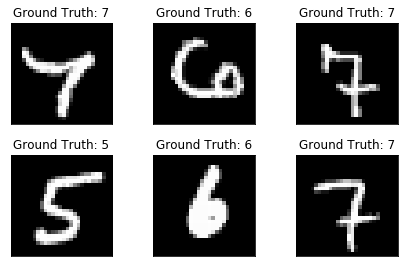

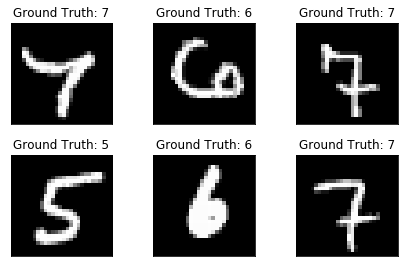

In [6]:

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [9]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [39]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), r'C:\Users\sahaj\Anaconda3\envs\chartextract\CHART_EXTRACTION\model.pth')
            torch.save(optimizer.state_dict(), r'C:\Users\sahaj\Anaconda3\envs\chartextract\CHART_EXTRACTION\optimizer.pth')

In [11]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/Users/ak/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/Users/ak/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.268458
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.268337
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.274000
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.251669
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.236826
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.223578
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153440
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.096371
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.974112
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.944348
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.839604
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.765900
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.699910
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.690938
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.508513
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.390797
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.280941
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.327438
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.275452
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.386473
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.439076
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.450277
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.394420
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.267425
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.274844
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.498097
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.366652
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.386702
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.315632
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.293077
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.434222
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.181149
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.390768
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.379620
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.281829
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.320758
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.365776
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.668646
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.322950


In [54]:
print (network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [55]:
mymodel=models.resnet50(pretrained=True)
print (mymodel)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/ak/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

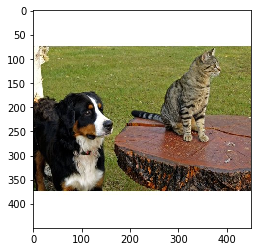

In [44]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('/Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data/dogs.png')
plt.imshow(img)

In [48]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [45]:
model = network

In [46]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('/Users/ak/Documents/GitHub/Lifelong-Learning/MNIST_data/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [50]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

RuntimeError: Given groups=1, weight of size [10, 1, 5, 5], expected input[1, 3, 224, 224] to have 1 channels, but got 3 channels instead

In [28]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.93592983, 239, 'Bernese_mountain_dog'),
 (0.038448066, 241, 'EntleBucher'),
 (0.023756348, 240, 'Appenzeller'),
 (0.0018181865, 238, 'Greater_Swiss_Mountain_dog'),
 (9.113341e-06, 214, 'Gordon_setter'))

In [29]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [30]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [31]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

239

In [34]:
from lime import lime_image

In [35]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

In [36]:
from skimage.segmentation import mark_boundaries

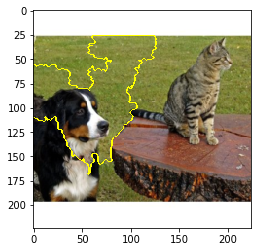

In [37]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

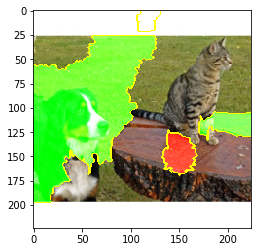

In [38]:

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)